<a href="https://colab.research.google.com/github/bman222112/ECE551/blob/main/Module%203_Traditional%20Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<p style="font-size:28px;font-weight:bold;">Module 3 - Traditional Learning</p>
Now that we have all of our data features and labels, we can try applying different learning algorithms to the data. </br>This data will be processed as a multi-class training problem, and performance will be checked.

In [1]:
!curl -s https://packagecloud.io/install/repositories/github/git-lfs/script.deb.sh | sudo bash
!sudo apt-get install git-lfs

Detected operating system as Ubuntu/jammy.
Checking for curl...
Detected curl...
Checking for gpg...
Detected gpg...
Detected apt version as 2.4.14
Running apt-get update... done.
Installing apt-transport-https... done.
Installing /etc/apt/sources.list.d/github_git-lfs.list...done.
Importing packagecloud gpg key... Packagecloud gpg key imported to /etc/apt/keyrings/github_git-lfs-archive-keyring.gpg
done.
Running apt-get update... done.

The repository is setup! You can now install packages.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following packages will be upgraded:
  git-lfs
1 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
Need to get 8,917 kB of archives.
After this operation, 8,712 kB of additional disk space will be used.
Get:1 https://packagecloud.io/github/git-lfs/ubuntu jammy/main amd64 git-lfs amd64 3.7.0 [8,917 kB]
Fetched 8,917 kB in 0s (20.7 MB/s)
debconf: unable to initialize frontend: Dialog
debco

In [2]:
%cd /content
!git clone https://www.github.com/bman222112/ECE551.git
%cd /content/ECE551

/content
Cloning into 'ECE551'...
remote: Enumerating objects: 1024, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 1024 (delta 4), reused 3 (delta 1), pack-reused 1009 (from 2)
Receiving objects: 100% (1024/1024), 749.76 MiB | 28.76 MiB/s, done.
Resolving deltas: 100% (21/21), done.
Updating files: 100% (949/949), done.
Filtering content: 100% (2/2), 252.93 MiB | 55.84 MiB/s, done.
/content/ECE551


In [3]:
import librosa
import numpy as np
import os
import matplotlib.pyplot as plt
import torchaudio

First, load all of the data and the labels produced in Module 2

In [4]:
LFCC = np.load("2D_LFCC.npy");
MFCC = np.load("2D_MFCC.npy");
LPC = np.load("2D_LPC.npy");
labels = np.load("Labels.npy");

Label definitions are saved so we can reference them during testing later

In [5]:
label_defs = ["Pump 1 Start", "Pump 1 Run", "Pump 1 Stop", "Pump 2 Start", "Pump 2 Run", "Pump 2 Stop", "Pump 3 Start", "Pump 3 Run", "Pump 3 Stop", "Pump 4 Start", "Pump 4 Run", "Pump 4 Stop"];

We will be selecting 90% of the dataset for training, and 10% for testing. To ensure a random distribution of the various classes, we will select random indicies from 90% of the dataset for training, and the remaining 10% will be randomly chosen for the test dataset. List comprehension is used below to accomplish this. </br>Finally, from the full data, the indicies are used to create train and test arrays for each feature extraction method.

In [6]:
import random
trainInds = random.sample(range(len(labels)),round(len(labels)*0.9));
testInds = [item for item in random.sample(range(len(labels)),round(len(labels))) if item not in trainInds];
LFCC_train = LFCC[trainInds];
LFCC_test = LFCC[testInds];
MFCC_train = MFCC[trainInds];
MFCC_test = MFCC[testInds];
LPC_train = LPC[trainInds];
LPC_test = LPC[testInds];
Y_test = labels[testInds];
Y_train = labels[trainInds];

<p style="font-size:20px;font-weight:bold;">K-Nearest Neighbors Classifier</p>
We will start with a KNN classifier, calculating the F1 scores for each of the different feature extraction methods, along with Confusion Matricies and ROC curves.

In [7]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier()

In [9]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import f1_score
y_train_knn_pred_LFCC = cross_val_predict(knn_clf, LFCC_train, Y_train, cv=3)
y_train_knn_pred_MFCC = cross_val_predict(knn_clf, MFCC_train, Y_train, cv=3)
y_train_knn_pred_LPC = cross_val_predict(knn_clf, LPC_train, Y_train, cv=3)
print(f"LFCC KNN F1 Score: {f1_score(Y_train, y_train_knn_pred_LFCC, average='macro')}");
print(f"MFCC KNN F1 Score: {f1_score(Y_train, y_train_knn_pred_MFCC, average='macro')}");
print(f"LPC  KNN F1 Score: {f1_score(Y_train, y_train_knn_pred_LPC, average='macro')}");

LFCC KNN F1 Score: 0.9994047543123424
MFCC KNN F1 Score: 1.0
LPC  KNN F1 Score: 0.9981924510839102


<p>As a point of comparison across all models, let's see how many parameters each model has. We can get the list of hyperparameters by calling <span style="color:blue;">get_params</span> and printing the keys. Below is the list of parameters for a KNN model</p>
<p>KNN models do not rely on learned features or weights like other models, absorbing the entire dataset during training instead. This means that the number of "learned" features is equivalent to the size of the training dataset. We can see this below</p>

In [10]:
KNN_Params = knn_clf.get_params(deep=True).keys();
print(f"KNN has {len(KNN_Params)} parameters:\n{list(KNN_Params)}");
knn_clf.fit(MFCC_train, Y_train);
print(f"Features Fit: {knn_clf.n_features_in_}\nSamples Fit: {knn_clf.n_samples_fit_}");

KNN has 8 parameters:
['algorithm', 'leaf_size', 'metric', 'metric_params', 'n_jobs', 'n_neighbors', 'p', 'weights']
Features Fit: 2353
Samples Fit: 826


In [11]:
from sklearn.metrics import confusion_matrix

print("LFCC Confusion Matrix:");
print(confusion_matrix(Y_train, y_train_knn_pred_LFCC))
print("\n\nMFCC Confusion Matrix:");
print(confusion_matrix(Y_train, y_train_knn_pred_MFCC))
print("\n\nLPC Confusion Matrix:");
print(confusion_matrix(Y_train, y_train_knn_pred_LPC))

LFCC Confusion Matrix:
[[ 42   0   0   0   0   0   0   0   0   0   0   0]
 [  0  44   0   0   0   0   0   0   0   0   0   0]
 [  0   0  46   0   0   0   0   0   0   0   0   0]
 [  0   0   0  46   0   0   0   0   0   0   0   0]
 [  0   0   0   0  46   0   0   0   0   0   0   0]
 [  0   0   0   0   0  46   0   0   0   0   0   0]
 [  0   0   0   0   0   0 139   1   0   0   0   0]
 [  0   0   0   0   0   0   0 140   0   0   0   0]
 [  0   0   0   0   0   0   0   0 133   0   0   0]
 [  0   0   0   0   0   0   0   0   0  47   0   0]
 [  0   0   0   0   0   0   0   0   0   0  48   0]
 [  0   0   0   0   0   0   0   0   0   0   0  48]]


MFCC Confusion Matrix:
[[ 42   0   0   0   0   0   0   0   0   0   0   0]
 [  0  44   0   0   0   0   0   0   0   0   0   0]
 [  0   0  46   0   0   0   0   0   0   0   0   0]
 [  0   0   0  46   0   0   0   0   0   0   0   0]
 [  0   0   0   0  46   0   0   0   0   0   0   0]
 [  0   0   0   0   0  46   0   0   0   0   0   0]
 [  0   0   0   0   0   0 140   0

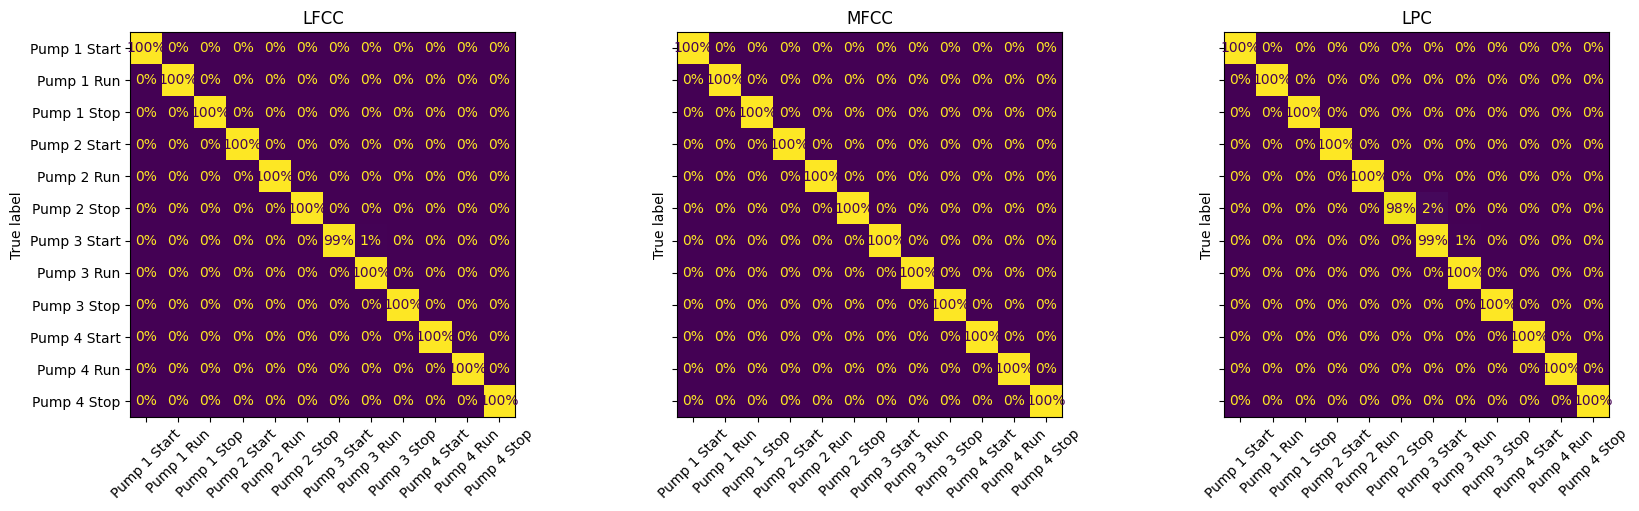

In [12]:
from sklearn.metrics import ConfusionMatrixDisplay
f, axes = plt.subplots(1, 3, figsize=(20, 5), sharey='row')

ConfusionMatrixDisplay.from_predictions(Y_train, y_train_knn_pred_LFCC, normalize="true", values_format=".0%", display_labels=label_defs, xticks_rotation=45, ax=axes[0], colorbar=False)
axes[0].set_title("LFCC");
axes[0].set_xlabel("");
ConfusionMatrixDisplay.from_predictions(Y_train, y_train_knn_pred_MFCC, normalize="true", values_format=".0%", display_labels=label_defs, xticks_rotation=45, ax=axes[1], colorbar=False)
axes[1].set_title("MFCC");
axes[1].set_xlabel("");
ConfusionMatrixDisplay.from_predictions(Y_train, y_train_knn_pred_LPC, normalize="true", values_format=".0%", display_labels=label_defs, xticks_rotation=45, ax=axes[2], colorbar=False)
axes[2].set_title("LPC");
axes[2].set_xlabel("");

In order to generate ROC curves for a multi-class problem, we need to choose a method of comparison. Here, the Label Binarizer function in SciKit-Learn will be used to transform this multi-class problem into a set of One-vs-Rest problems.

In [13]:
from sklearn.preprocessing import LabelBinarizer

label_binarizer = LabelBinarizer().fit(Y_train)
y_onehot_test = label_binarizer.transform(Y_test)

np.set_printoptions(threshold=12, edgeitems=12)
print(f"Original labels:\n{Y_test}")
print(f"\n\nOne-vs-Rest binarization: \n{y_onehot_test}");

Original labels:
[ 1.  6.  5.  8.  0.  0.  6.  6.  8.  7.  6.  0. ...  1.  7. 11.  8.  8.
  8.  0.  3.  9.  8.  4.  5.]


One-vs-Rest binarization: 
[[0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0]
 ...
 [0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0]]


Much of the following code is from SciKit-Learn reference material for producing ROC curves for a multi-class problem. This code calculates micro-, and macro-averages for the ROC curves, and plots these along with the ROC Area Under Curve values.

In [17]:
from itertools import cycle
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_auc_score, roc_curve

def plotROCs(classifier, train_X, train_Y, test_X, test_Y, onehot, axis, labels, title):
    classifier.fit(train_X,train_Y)
    y_scores = classifier.predict_proba(test_X);

    fpr, tpr, roc_auc = dict(), dict(), dict()
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(onehot.ravel(), y_scores.ravel())

    for i in range(len(labels)):
        fpr[i], tpr[i], _ = roc_curve(onehot[:, i], y_scores[:, i])

    fpr_grid = np.linspace(0.0, 1.0, 1000)

    # Interpolate all ROC curves at these points
    mean_tpr = np.zeros_like(fpr_grid)

    for i in range(len(labels)):
        mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation

    # Average it and compute AUC
    mean_tpr /= len(labels)

    fpr["macro"] = fpr_grid
    tpr["macro"] = mean_tpr


    axis.plot(
        fpr["micro"],
        tpr["micro"],
        label=f"micro-average ROC curve (AUC = {roc_auc_score(Y_test, y_scores, multi_class='ovr', average='micro',):.2f})",
        color="deeppink",
        linestyle=":",
        linewidth=4,
    )

    axis.plot(
        fpr["macro"],
        tpr["macro"],
        label=f"macro-average ROC curve (AUC = {roc_auc_score(Y_test, y_scores, multi_class='ovr', average='macro',):.2f})",
        color="navy",
        linestyle=":",
        linewidth=4,
    )

    colors = cycle(["aqua", "darkorange", "cornflowerblue"])
    for class_id, color in zip(range(len(labels)), colors):
        RocCurveDisplay.from_predictions(
            onehot[:, class_id],
            y_scores[:, class_id],
            name=f"ROC curve for {labels[class_id]}",
            ax=axis,
            plot_chance_level=(class_id == 2),
            despine=True,
        )

    _ = axis.set(
        xlabel="False Positive Rate",
        ylabel="True Positive Rate",
        title=title,
    )

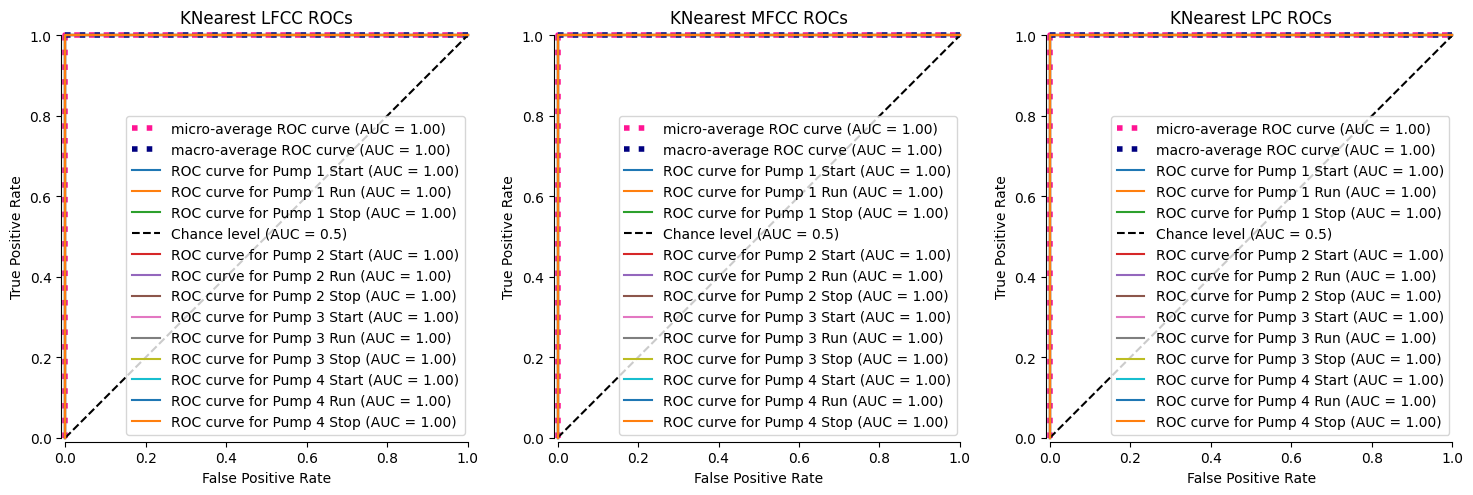

In [18]:
fig, ax = plt.subplots(1,3,figsize=(18,6))
plotROCs(knn_clf, LFCC_train, Y_train, LFCC_test, Y_test, y_onehot_test, ax[0], label_defs, "KNearest LFCC ROCs");
plotROCs(knn_clf, MFCC_train, Y_train, MFCC_test, Y_test, y_onehot_test, ax[1], label_defs, "KNearest MFCC ROCs");
plotROCs(knn_clf, LPC_train, Y_train, LPC_test, Y_test, y_onehot_test, ax[2], label_defs, "KNearest LPC ROCs");

<p style="font-size: 28px; font-weight: bold;">Random Forest Testing</p>
Next, we will explore how the RandomForest Classifier works with the same set of feature-extracted data

In [19]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
y_train_rf_pred_LFCC = cross_val_predict(forest_clf, LFCC_train, Y_train, cv=3)
y_train_rf_pred_MFCC = cross_val_predict(forest_clf, MFCC_train, Y_train, cv=3)
y_train_rf_pred_LPC = cross_val_predict(forest_clf, LPC_train, Y_train, cv=3)
print(f"LFCC RF F1 Score: {f1_score(Y_train, y_train_rf_pred_LFCC, average='macro')}");
print(f"MFCC RF F1 Score: {f1_score(Y_train, y_train_rf_pred_MFCC, average='macro')}");
print(f"LPC  RF F1 Score: {f1_score(Y_train, y_train_rf_pred_LPC, average='macro')}");

LFCC RF F1 Score: 1.0
MFCC RF F1 Score: 1.0
LPC  RF F1 Score: 0.9969842838735682


<p>Like above, let's check the the number of parameters for the RandomForest classifier. These are hyperparameters for this model</p>
<p>Within the RandomForst classifier, we have a set of Feature Importances that match the length of the number of training samples. This is also shown below.</p>
<p>Finally, for the random forest, we have a set of Decision Trees responsible for the fit. This was specified above with the n_estimators value, but can be verified after fit.</p>

In [20]:
RF_Params = forest_clf.get_params(deep=True).keys();
print(f"KNN has {len(RF_Params)} parameters:\n{list(RF_Params)}");
forest_clf.fit(MFCC_train,Y_train)
print(f"Feature Importances: {forest_clf.feature_importances_.shape[0]}");
print(f"Samples: {MFCC_train.shape[1]}");
print(f"Estimators: {forest_clf.n_estimators}");

KNN has 19 parameters:
['bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'monotonic_cst', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start']
Feature Importances: 2353
Samples: 2353
Estimators: 100


In [21]:
print("LFCC Confusion Matrix:");
print(confusion_matrix(Y_train, y_train_rf_pred_LFCC))
print("\n\nMFCC Confusion Matrix:");
print(confusion_matrix(Y_train, y_train_rf_pred_MFCC))
print("\n\nLPC Confusion Matrix:");
print(confusion_matrix(Y_train, y_train_rf_pred_LPC))

LFCC Confusion Matrix:
[[ 42   0   0   0   0   0   0   0   0   0   0   0]
 [  0  44   0   0   0   0   0   0   0   0   0   0]
 [  0   0  46   0   0   0   0   0   0   0   0   0]
 [  0   0   0  46   0   0   0   0   0   0   0   0]
 [  0   0   0   0  46   0   0   0   0   0   0   0]
 [  0   0   0   0   0  46   0   0   0   0   0   0]
 [  0   0   0   0   0   0 140   0   0   0   0   0]
 [  0   0   0   0   0   0   0 140   0   0   0   0]
 [  0   0   0   0   0   0   0   0 133   0   0   0]
 [  0   0   0   0   0   0   0   0   0  47   0   0]
 [  0   0   0   0   0   0   0   0   0   0  48   0]
 [  0   0   0   0   0   0   0   0   0   0   0  48]]


MFCC Confusion Matrix:
[[ 42   0   0   0   0   0   0   0   0   0   0   0]
 [  0  44   0   0   0   0   0   0   0   0   0   0]
 [  0   0  46   0   0   0   0   0   0   0   0   0]
 [  0   0   0  46   0   0   0   0   0   0   0   0]
 [  0   0   0   0  46   0   0   0   0   0   0   0]
 [  0   0   0   0   0  46   0   0   0   0   0   0]
 [  0   0   0   0   0   0 140   0

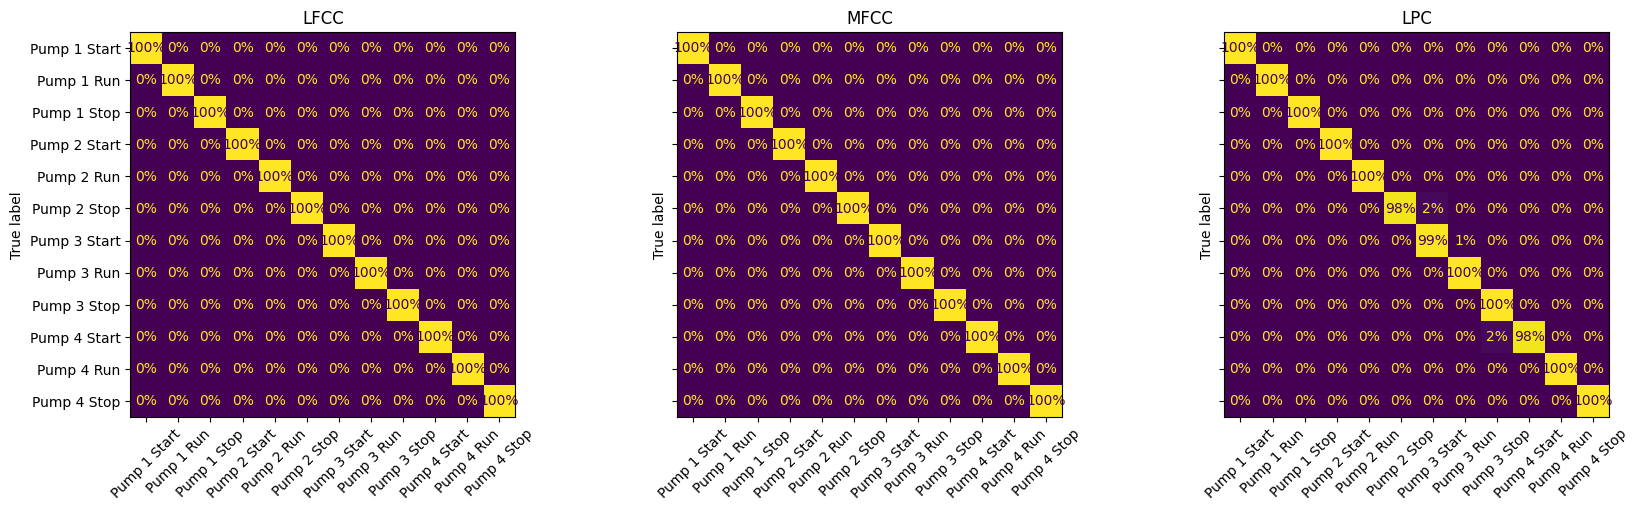

In [22]:
from sklearn.metrics import ConfusionMatrixDisplay
f, axes = plt.subplots(1, 3, figsize=(20, 5), sharey='row')

ConfusionMatrixDisplay.from_predictions(Y_train, y_train_rf_pred_LFCC, normalize="true", values_format=".0%", display_labels=label_defs, xticks_rotation=45, ax=axes[0], colorbar=False)
axes[0].set_title("LFCC");
axes[0].set_xlabel("");
ConfusionMatrixDisplay.from_predictions(Y_train, y_train_rf_pred_MFCC, normalize="true", values_format=".0%", display_labels=label_defs, xticks_rotation=45, ax=axes[1], colorbar=False)
axes[1].set_title("MFCC");
axes[1].set_xlabel("");
ConfusionMatrixDisplay.from_predictions(Y_train, y_train_rf_pred_LPC, normalize="true", values_format=".0%", display_labels=label_defs, xticks_rotation=45, ax=axes[2], colorbar=False)
axes[2].set_title("LPC");
axes[2].set_xlabel("");

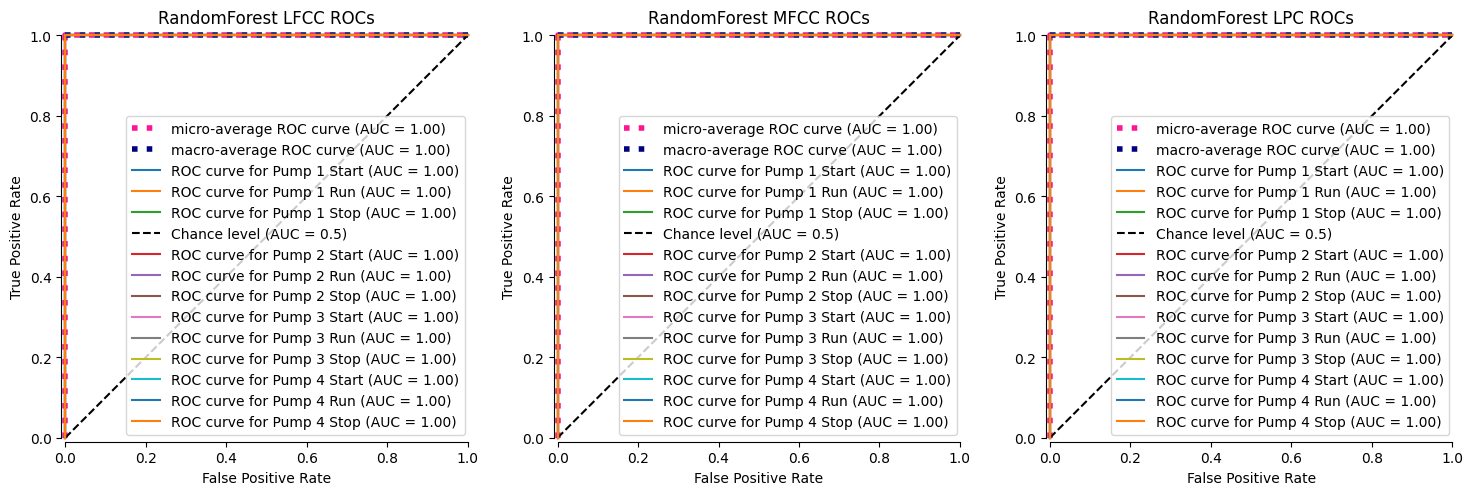

In [23]:
fig, ax = plt.subplots(1,3,figsize=(18,6))
plotROCs(forest_clf, LFCC_train, Y_train, LFCC_test, Y_test, y_onehot_test, ax[0], label_defs, "RandomForest LFCC ROCs");
plotROCs(forest_clf, MFCC_train, Y_train, MFCC_test, Y_test, y_onehot_test, ax[1], label_defs, "RandomForest MFCC ROCs");
plotROCs(forest_clf, LPC_train, Y_train, LPC_test, Y_test, y_onehot_test, ax[2], label_defs, "RandomForest LPC ROCs");